In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections

import matplotlib.pyplot as plt


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

np.random.seed(37)

<ipython-input-1-d4dc67f16e7e>:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
X = pd.read_csv("train.csv")
test_set = pd.read_csv("test.csv")
labels = pd.read_csv("labels.csv")

In [ ]:
test_set=test_set["Text"]
labels = labels["Score"]

In [3]:
X.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,220291,B0034EDLS2,AVF82BC7S0IO7,Kbrown,0,0,5,1332806400,Very Good,I received this product early from the seller! They are a very tastey & a Great mid-day snack. I have shared them with my Glutten Free Friends & they will be ordering this product & more very soon.
1,225833,B001I7HJE4,A1YUL9PCJR3JTY,"O. Brown ""Ms. O. Khannah-Brown""",1,1,5,1190160000,"Organic, Kosher, Tasty Assortment of Premium Teas & Teasans","*****<br />Numi's Collection Assortment Melange includes:<br />5 Herbal Teas (caffeine-free, also called ""teasans""):<br />* Dry Desert Lime: Lime Herbal Teasan<br />* Fields of Gold: Lemongrass Herbal Teasan<br />* Red Mellow Bush: Rooibos Herbal Teasan<br />* Bushmen's Brew: Honeybush Herbal Teasan<br />* Simply Mint: Moroccan Mint<br /><br />2 Green Teas (lower in caffeine):<br />* Temple of Heaven: Gunpowder Green Tea<br />* Monkey King: Jasmine Green Tea<br /><br />2 Black Teas (contain caffeine):<br />* Chinese Breakfast: Yunnan Black Tea<br />* Smoky Tarry: Lapsang Souchong Black Tea<br /><br />This is a total of nine different teas, two tea bags of each one in each box. Numi teas are known for their high-quality, organic and kosher ingredients, and in my opinion, are some of the tastiest and best teas I have ever tried. They do not include artificial ingredients or flavorings.<br /><br />On the box, the manufacturer writes: ""From mist-covered mountains to sun-drenched deserts to fertile fields, we proudly bring you our tea palette. The flavors range from smooth earthiness, and light floral scents, to refreshingly sweet and sour notes. What they all share is the recollection of how some Ancient One tamed fire and water to coexist harmoniously, and steeped in them the gifts of Nature. Since that distant past, people have soothed, roused, healed, explored and celebrated with these wonderful infusions. We encourage you to do the same with Numi's finest.""<br /><br />The price is perfect, a big savings over single boxes. If you like Numi teas and want to sample a wonderful assortment, get it---you won't be sorry. There may be some you like and others you don't, but sampling them will be a delightful experience. If you are new to Numi this is an excellent way to sample their high-quality teas. I do not think you could find a better source of premium tea than Numi.<br /><br />Highly recommended.<br />*****"
2,350901,B000LKTB90,A1BBPP1EC75JX4,"Johan Bollen ""gekhond""",0,0,5,1285977600,"excellent gluten-free spaghetti: great taste, great structure","I was very careful not to overcook this pasta, making sure to take a bite every minute or so, and rinsed it with water as soon as it was al dente. It was all very easy and the result was absolutely *PERFECT*. This is one great tasting gluten-free pasta! My wife is Italian and she claims it is on par with some of the best wheat-based pasta she has had. My daughter has celiac disease and loved it too. I did notice a slight corn taste, but it was very pleasant and certainly not too pronounced. You could serve this pasta to your guests and they'd have no idea that this is a gluten-free, quinoa-based pasta.<br /><br />This product has tremendous value to us because it uses quinoa flour (one of my favorite ""grains""), there are only two (2!) ingredients (quinoa and corn flour) that are both are organic, it is produced in a gluten-free facility, tastes great and has great structure (very nice al dente). A perfect combination!<br /><br />This product gets 5 stars and a glowing endorsement from all of us, and we are 2 discriminating foodies and a 7 year old with celiac disease."
3,299801,B001HXJPS2,A5QSI9MNS8NMS,M. Esaili,0,0,5,1338163200,Lindt is Lindt,Buying this multi-pack I was misled by the picture with whole hazel nuts. (Another proof how important is to read). But no problem. The chocolate is delicious like any Lindt's chocolate.
4,48472,B006H34CUS,A20IBAIRSNBEAQ,Chelsea,0

In [4]:
X.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,426340.000000,426340.000000,426340.000000,426340.000000,4.263400e+05
mean,284300.799618,1.733159,2.220244,4.183455,1.296222e+09
std,164012.600602,7.328184,8.014894,1.310577,4.808061e+07
min,1.000000,0.000000,0.000000,1.000000,9.408096e+08
25%,142363.750000,0.000000,0.000000,4.000000,1.271203e+09
50%,284308.500000,0.000000,1.000000,5.000000,1.311034e+09
75%,426183.250000,2.000000,2.000000,5.000000,1.332720e+09
max,568454.000000,844.000000,923.000000,5.000000,1.351210e+09


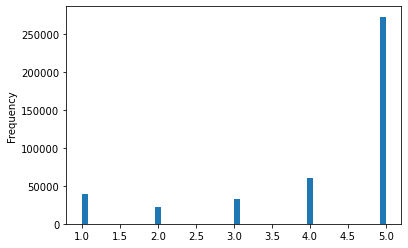

In [5]:
X['Score'].plot(bins=50, kind='hist') 

In [6]:
X['length'] = X['Text'].apply(len)
X.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,length
0,220291,B0034EDLS2,AVF82BC7S0IO7,Kbrown,0,0,5,1332806400,Very Good,I received this product early from the seller! They are a very tastey & a Great mid-day snack. I have shared them with my Glutten Free Friends & they will be ordering this product & more very soon.,197
1,225833,B001I7HJE4,A1YUL9PCJR3JTY,"O. Brown ""Ms. O. Khannah-Brown""",1,1,5,1190160000,"Organic, Kosher, Tasty Assortment of Premium Teas & Teasans","*****<br />Numi's Collection Assortment Melange includes:<br />5 Herbal Teas (caffeine-free, also called ""teasans""):<br />* Dry Desert Lime: Lime Herbal Teasan<br />* Fields of Gold: Lemongrass Herbal Teasan<br />* Red Mellow Bush: Rooibos Herbal Teasan<br />* Bushmen's Brew: Honeybush Herbal Teasan<br />* Simply Mint: Moroccan Mint<br /><br />2 Green Teas (lower in caffeine):<br />* Temple of Heaven: Gunpowder Green Tea<br />* Monkey King: Jasmine Green Tea<br /><br />2 Black Teas (contain caffeine):<br />* Chinese Breakfast: Yunnan Black Tea<br />* Smoky Tarry: Lapsang Souchong Black Tea<br /><br />This is a total of nine different teas, two tea bags of each one in each box. Numi teas are known for their high-quality, organic and kosher ingredients, and in my opinion, are some of the tastiest and best teas I have ever tried. They do not include artificial ingredients or flavorings.<br /><br />On the box, the manufacturer writes: ""From mist-covered mountains to sun-drenched deserts to fertile fields, we proudly bring you our tea palette. The flavors range from smooth earthiness, and light floral scents, to refreshingly sweet and sour notes. What they all share is the recollection of how some Ancient One tamed fire and water to coexist harmoniously, and steeped in them the gifts of Nature. Since that distant past, people have soothed, roused, healed, explored and celebrated with these wonderful infusions. We encourage you to do the same with Numi's finest.""<br /><br />The price is perfect, a big savings over single boxes. If you like Numi teas and want to sample a wonderful assortment, get it---you won't be sorry. There may be some you like and others you don't, but sampling them will be a delightful experience. If you are new to Numi this is an excellent way to sample their high-quality teas. I do not think you could find a better source of premium tea than Numi.<br /><br />Highly recommended.<br />*****",1938
2,350901,B000LKTB90,A1BBPP1EC75JX4,"Johan Bollen ""gekhond""",0,0,5,1285977600,"excellent gluten-free spaghetti: great taste, great structure","I was very careful not to overcook this pasta, making sure to take a bite every minute or so, and rinsed it with water as soon as it was al dente. It was all very easy and the result was absolutely *PERFECT*. This is one great tasting gluten-free pasta! My wife is Italian and she claims it is on par with some of the best wheat-based pasta she has had. My daughter has celiac disease and loved it too. I did notice a slight corn taste, but it was very pleasant and certainly not too pronounced. You could serve this pasta to your guests and they'd have no idea that this is a gluten-free, quinoa-based pasta.<br /><br />This product has tremendous value to us because it uses quinoa flour (one of my favorite ""grains""), there are only two (2!) ingredients (quinoa and corn flour) that are both are organic, it is produced in a gluten-free facility, tastes great and has great structure (very nice al dente). A perfect combination!<br /><br />This product gets 5 stars and a glowing endorsement from all of us, and we are 2 discriminating foodies and a 7 year old with celiac disease.",1084
3,299801,B001HXJPS2,A5QSI9MNS8NMS,M. Esaili,0,0,5,1338163200,Lindt is Lindt,Buying this multi-pack I was misled by the picture with whole hazel nuts. (Another proof how important is to read). But no problem. The chocolate is delicious like any Lindt's chocolate.,186
4,48472,B006H34CUS

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000279A53D9E80>,
      dtype=object)

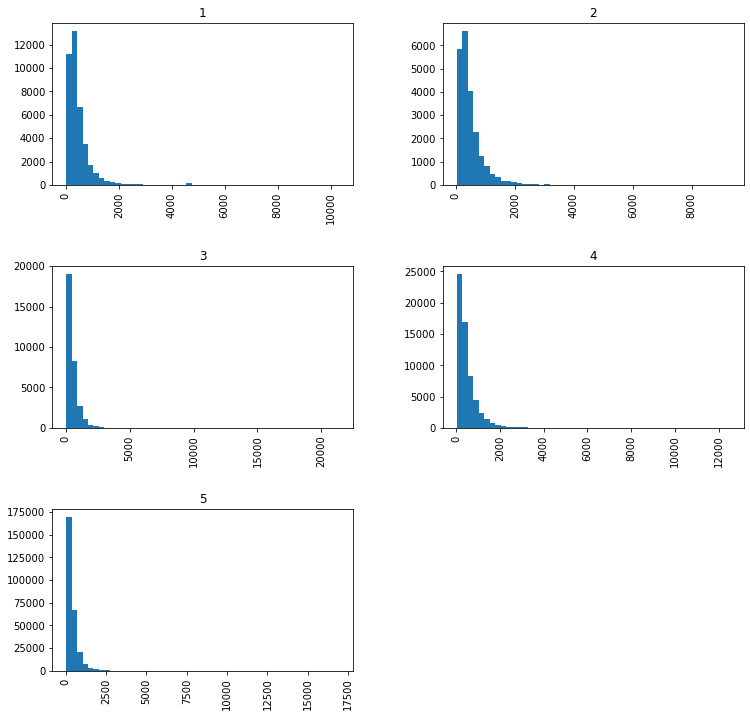

In [7]:
X.hist(column='length', by='Score', bins=50,figsize=(12,12))

In [8]:
    def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(input_text):
        return input_text.lower()
    
    def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(X, y=None, **fit_params):
        return self
    
    def transform(X):
        clean_X = remove_mentions(X)
        clean_X = remove_urls(clean_X)
        clean_X = emoji_oneword(clean_X)
        clean_X = remove_punctuation(clean_X)
        clean_X = remove_digits(clean_X)
        clean_X = to_lower(clean_X)
        clean_X = remove_stopwords(clean_X)
        clean_X = stemming(clean_X)
        return clean_X


In [9]:
review = X['Text'][0]
review

'I received this product early from the seller! They are a very tastey & a Great mid-day snack. I have shared them with my Glutten Free Friends & they will be ordering this product & more very soon.'

In [10]:
t = transform(review)
t

'receiv product earli seller tastey great mid day snack share glutten free friend order product soon'

In [11]:
from nltk import wordpunct_tokenize
X['Tokens'] = X['Text'].apply(wordpunct_tokenize)
X['Tokens'][0]

['I',
 'received',
 'this',
 'product',
 'early',
 'from',
 'the',
 'seller',
 '!',
 'They',
 'are',
 'a',
 'very',
 'tastey',
 '&',
 'a',
 'Great',
 'mid',
 '-',
 'day',
 'snack',
 '.',
 'I',
 'have',
 'shared',
 'them',
 'with',
 'my',
 'Glutten',
 'Free',
 'Friends',
 '&',
 'they',
 'will',
 'be',
 'ordering',
 'this',
 'product',
 '&',
 'more',
 'very',
 'soon',
 '.']

In [12]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()
#X['Stemmed'] = X['Tokens'].apply(stemmer)
X['Stemmed'] = X['Tokens'].apply(lambda x: [stemmer.stem(y) for y in x])
X['Stemmed'][0]

['i',
 'receiv',
 'this',
 'product',
 'earli',
 'from',
 'the',
 'seller',
 '!',
 'they',
 'are',
 'a',
 'veri',
 'tastey',
 '&',
 'a',
 'great',
 'mid',
 '-',
 'day',
 'snack',
 '.',
 'i',
 'have',
 'share',
 'them',
 'with',
 'my',
 'glutten',
 'free',
 'friend',
 '&',
 'they',
 'will',
 'be',
 'order',
 'this',
 'product',
 '&',
 'more',
 'veri',
 'soon',
 '.']

In [13]:
X['StemmedJoined'] = X['Stemmed'].apply(' '.join)

In [14]:
X.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,length,Tokens,Stemmed,StemmedJoined
0,220291,B0034EDLS2,AVF82BC7S0IO7,Kbrown,0,0,5,1332806400,Very Good,I received this product early from the seller! They are a very tastey & a Great mid-day snack. I have shared them with my Glutten Free Friends & they will be ordering this product & more very soon.,197,"[I, received, this, product, early, from, the, seller, !, They, are, a, very, tastey, &, a, Great, mid, -, day, snack, ., I, have, shared, them, with, my, Glutten, Free, Friends, &, they, will, be, ordering, this, product, &, more, very, soon, .]","[i, receiv, this, product, earli, from, the, seller, !, they, are, a, veri, tastey, &, a, great, mid, -, day, snack, ., i, have, share, them, with, my, glutten, free, friend, &, they, will, be, order, this, product, &, more, veri, soon, .]",i receiv this product earli from the seller ! they are a veri tastey & a great mid - day snack . i have share them with my glutten free friend & they will be order this product & more veri soon .
1,225833,B001I7HJE4,A1YUL9PCJR3JTY,"O. Brown ""Ms. O. Khannah-Brown""",1,1,5,1190160000,"Organic, Kosher, Tasty Assortment of Premium Teas & Teasans","*****<br />Numi's Collection Assortment Melange includes:<br />5 Herbal Teas (caffeine-free, also called ""teasans""):<br />* Dry Desert Lime: Lime Herbal Teasan<br />* Fields of Gold: Lemongrass Herbal Teasan<br />* Red Mellow Bush: Rooibos Herbal Teasan<br />* Bushmen's Brew: Honeybush Herbal Teasan<br />* Simply Mint: Moroccan Mint<br /><br />2 Green Teas (lower in caffeine):<br />* Temple of Heaven: Gunpowder Green Tea<br />* Monkey King: Jasmine Green Tea<br /><br />2 Black Teas (contain caffeine):<br />* Chinese Breakfast: Yunnan Black Tea<br />* Smoky Tarry: Lapsang Souchong Black Tea<br /><br />This is a total of nine different teas, two tea bags of each one in each box. Numi teas are known for their high-quality, organic and kosher ingredients, and in my opinion, are some of the tastiest and best teas I have ever tried. They do not include artificial ingredients or flavorings.<br /><br />On the box, the manufacturer writes: ""From mist-covered mountains to sun-drenched deserts to fertile fields, we proudly bring you our tea palette. The flavors range from smooth earthiness, and light floral scents, to refreshingly sweet and sour notes. What they all share is the recollection of how some Ancient One tamed fire and water to coexist harmoniously, and steeped in them the gifts of Nature. Since that distant past, people have soothed, roused, healed, explored and celebrated with these wonderful infusions. We encourage you to do the same with Numi's finest.""<br /><br />The price is perfect, a big savings over single boxes. If you like Numi teas and want to sample a wonderful assortment, get it---you won't be sorry. There may be some you like and others you don't, but sampling them will be a delightful experience. If you are new to Numi this is an excellent way to sample their high-quality teas. I do not think you could find a better source of premium tea than Numi.<br /><br />Highly recommended.<br />*****",1938,"[*****<, br, />, Numi, ', s, Collection, Assortment, Melange, includes, :<, br, />, 5, Herbal, Teas, (, caffeine, -, free, ,, also, called, "", teasans, ""):<, br, />*, Dry, Desert, Lime, :, Lime, Herbal, Teasan, <, br, />*, Fields, of, Gold, :, Lemongrass, Herbal, Teasan, <, br, />*, Red, Mellow, Bush, :, Rooibos, Herbal, Teasan, <, br, />*, Bushmen, ', s, Brew, :, Honeybush, Herbal, Teasan, <, br, />*, Simply, Mint, :, Moroccan, Mint, <, br, /><, br, />, 2, Green, Teas, (, lower, in, caffeine, ):<, br, />*, Temple, of, Heaven, :, Gunpowder, Green, Tea, <, br, />*, Monkey, ...]","[*****<, br, />, numi, ', s, collect, assort, melang, includ, :<, br, />, 5, herbal, tea, (, caffein, -, free, ,, also, call, "", teasan, ""):<, br, />*, dri, desert, lime, :, lime, herbal, teasan, <, br, />*, field, 

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
bow_transformer = vec.fit(X['StemmedJoined'])

In [16]:
review_bow = bow_transformer.transform(X['StemmedJoined'])

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(review_bow)
review_tfidf = tfidf_transformer.transform(review_bow)

In [18]:
from sklearn.naive_bayes import MultinomialNB
review_detect_model = MultinomialNB().fit(review_tfidf, X['Score'])

In [19]:
all_predictions = review_detect_model.predict(review_tfidf)
from sklearn.metrics import classification_report
print (classification_report(X['Score'], all_predictions))

              precision    recall  f1-score   support

           1       0.85      0.11      0.19     39193
           2       0.35      0.00      0.00     22353
           3       0.76      0.00      0.01     31993
           4       0.73      0.01      0.02     60309
           5       0.65      1.00      0.79    272492

    accuracy                           0.65    426340
   macro avg       0.67      0.23      0.20    426340
weighted avg       0.67      0.65      0.52    426340



In [20]:
from sklearn.svm import LinearSVC
review_detect_model = LinearSVC().fit(review_tfidf, X['Score'])

all_predictions = review_detect_model.predict(review_tfidf)
from sklearn.metrics import classification_report
print (classification_report(X['Score'], all_predictions))

              precision    recall  f1-score   support

           1       0.75      0.78      0.76     39193
           2       0.76      0.36      0.49     22353
           3       0.69      0.43      0.53     31993
           4       0.66      0.34      0.45     60309
           5       0.82      0.97      0.89    272492

    accuracy                           0.79    426340
   macro avg       0.73      0.58      0.63    426340
weighted avg       0.78      0.79      0.77    426340



In [18]:
from sklearn.model_selection import train_test_split

rev_train, rev_test, score_train, score_test =\
train_test_split(X['Text'], X['Score'], test_size=0.2)

print(len(rev_train), len(rev_test), len(rev_train) + len(rev_test))

341072 85268 426340


### Naive Bayes

In [23]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(ngram_range=(1,3))),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', MultinomialNB()), 
])

pipeline.fit(rev_train,score_train)

predictions = pipeline.predict(rev_test)
print(classification_report(predictions,score_test))

              precision    recall  f1-score   support

           1       0.01      0.99      0.02        73
           2       0.00      0.00      0.00         0
           3       0.00      1.00      0.00        16
           4       0.00      1.00      0.01        33
           5       1.00      0.64      0.78     85146

    accuracy                           0.64     85268
   macro avg       0.20      0.73      0.16     85268
weighted avg       1.00      0.64      0.78     85268



### Support Vector Machine

In [24]:
from sklearn.svm import LinearSVC

clf_linearSVC_pipe = Pipeline([
    ('bow', CountVectorizer(ngram_range=(1,3))),  
    ('tfidf', TfidfTransformer()),  
    ("clf_linearSVC", LinearSVC()),  
])

clf_linearSVC_pipe.fit(rev_train,score_train)

predictedLinearSVC = clf_linearSVC_pipe.predict(test_set)
print(classification_report(predictedLinearSVC,labels))

              precision    recall  f1-score   support

           1       0.83      0.78      0.80      8319
           2       0.46      0.75      0.57      2700
           3       0.56      0.71      0.63      5077
           4       0.55      0.74      0.63      9101
           5       0.97      0.88      0.92     60071

    accuracy                           0.84     85268
   macro avg       0.67      0.77      0.71     85268
weighted avg       0.87      0.84      0.85     85268



### Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf_decisionTree_pipe = Pipeline([
    ('bow', CountVectorizer(ngram_range=(1, 3))),  
    ('tfidf', TfidfTransformer()),  
    ("clf_decisionTree", DecisionTreeClassifier()),  
])

clf_decisionTree_pipe.fit(rev_train,score_train)

predictedDecisionTree  = clf_decisionTree_pipe.predict(rev_test)
print(classification_report(predictedDecisionTree,score_test))

### Random Forest


In [30]:
from sklearn.ensemble import RandomForestClassifier

clf_randomForest_pipe = Pipeline([
    ('bow', CountVectorizer(ngram_range=(1, 3))),  
    ('tfidf', TfidfTransformer()),  
    ("clf_randomForest", RandomForestClassifier()),  
])

clf_randomForest_pipe.fit(rev_train,score_train)

predictedRandomForest = clf_randomForest_pipe.predict(rev_test)
print(classification_report(predictedRandomForest,score_test))

              precision    recall  f1-score   support

           1       0.42      0.98      0.59      3353
           2       0.36      0.99      0.53      1585
           3       0.36      0.99      0.53      2362
           4       0.36      0.99      0.53      4452
           5       1.00      0.74      0.85     73516

    accuracy                           0.77     85268
   macro avg       0.50      0.94      0.60     85268
weighted avg       0.91      0.77      0.81     85268



In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(TfidfVectorizer(min_df=5), LinearSVC())
param_grid = {"tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(rev_train,score_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.83
Best parameters:
{'tfidfvectorizer__ngram_range': (1, 3)}


In [24]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
X_train = vectorizer.transform(rev_train)
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort() 
feature_names = np.array(vectorizer.get_feature_names())

print("Features with lowest tfidf:\n{}".format(
    feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
    feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['grandsons br' 'fifty families' 'adult daughter was' 'my nabisco'
 'my nabisco oreo' 'my oldest grandson' 'to overindulge br'
 'guesswork involved' 'guesswork involved each' 'controlled portion of'
 'you put nabisco' 'was 200 calories' 'with five individual' 'was 200'
 'many calories my' 'older brother or' 'dedication to eating'
 'oldest grandson' 'oldest grandson ate' 'color with thin']
Features with highest tfidf: 
['kimchi' 'cavender' 'love love' 'love love love' 'crabmeat'
 'they are excellent' 'gochujang' 'catchup' 'fg' 'shiitakes' 'mm'
 'buy don' 'jf' 'good fat' 'ranch' 'la la' 'good good good' 'is is' 'word'
 'carmel']
